In [110]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Normalize, CenterCrop, Resize
from torchvision import datasets, transforms, models
from torch import nn
from torchvision.utils import save_image


from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
import os


GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive','image_color','image_color')
print(os.listdir(GOOGLE_DRIVE_PATH))

['README.md', '0.jpg', '.ipynb_checkpoints', 'train_landscape_images', 'landscape_images', '__pycache__', 'best.pt', 'train.py', 'best_25.pt', 'best_pretrain.pt', 'main.ipynb', 'colorize_data.py', 'basic_model.py', 'test.ipynb', 'test_pretrain.ipynb', '7.jpg', 'pretrain_helper.py', 'test_finetune_1.jpg', 'test_finetune_2.jpg']


In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

In [ ]:
!pip install import-ipynb
import import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=2bce8cf4bd5e2cefc98e99431ddded7d394c548ac993ffa284c73f39b0124354
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [ ]:
import colorize_data
from PIL import Image
from torch.autograd import Variable
import helper
import basic_model

In [ ]:
epoch_curr = 0

In [ ]:
def eccv16(pretrained=True):
	model = basic_model.ECCVGenerator()
	if(pretrained):
		import torch.utils.model_zoo as model_zoo
		model.load_state_dict(model_zoo.load_url('https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth',map_location='cpu',check_hash=True))
	return model

model = eccv16()

Downloading: "https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth" to /root/.cache/torch/hub/checkpoints/colorization_release_v2-9b330a0b.pth


  0%|          | 0.00/123M [00:00<?, ?B/s]

In [113]:
test_path = "/content/drive/MyDrive/image_color/image_color/7.jpg"


Train the pretrained model for 10 more epoch after freezing first three layers so as to improve accuracy of results. (Fine tuning model)


In [ ]:
import train
FILE = './checkpoints_pretrain.pth'

train_obj = train.Trainer(1e-2,10)
loss_best = 1e10
for epoch in range(10):
  count = 0 
  if epoch < 5:
        # freeze backbone layers
    for param in model.children():
      count +=1
      if count < 4: #freezing first 3 layers
        param.requires_grad = False
            
      else:
        for param in model.children():
          param.requires_grad = True
  print("Epoch number",epoch + epoch_curr+1)
  # Train for one epoch, then validate
  train_obj.train()
  with torch.no_grad():
    losses,model,optimizer = train_obj.validate()
  if losses < loss_best:
        loss_best = losses
        path_save = os.path.join(GOOGLE_DRIVE_PATH, 'best_pretrain.pt')
        #model.save(path_save)
        torch.save(model.state_dict(), path_save)
  checkpoint = {
      "epoch": epoch + epoch_curr+ 1,
      "model_state": model.state_dict(),
      "optim_state": optimizer.state_dict()
      }
  torch.save(checkpoint , FILE)

In [114]:
from PIL import Image
import numpy as np
from skimage import color
import torch
import torch.nn.functional as F
from IPython import embed


In [115]:
import pretrain_helper
from pretrain_helper import *

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 73 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


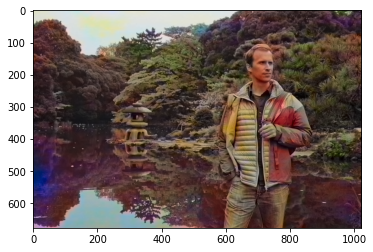

In [116]:
img = load_img(test_path)
(original, rs) = preprocess_img(img, HW=(256,256))
img_bw = postprocess_tens(original, torch.cat((0*original,0*original),dim=1))
out_img_eccv16 = postprocess_tens(original, model(rs).cpu())
plt.imshow(out_img_eccv16)
plt.show()

plt.imsave('test_finetune_2.jpg', out_img_eccv16)

Bonus question to modulate the hue of image. Allocated hue related to the channel that has maximum mean value. I.e. if the Red channel is dominant in image, hue of image is towards red tones. 

In [117]:
#bonus part to change hue
import torchvision.transforms.functional as F
import torchvision.transforms as T
def hue(image,arg1):
  hue = 0.0
  a,b = image.shape[0], image.shape[1]
  image_temp=torch.from_numpy(image)
  image_temp = image_temp.reshape(3,-1)
  sum_vals = torch.sum(image_temp,1)
  R_mean, G_mean ,B_mean = sum_vals[0],sum_vals[1],sum_vals[2]
  R_mean, G_mean ,B_mean = int(R_mean), int(G_mean) ,int(B_mean)
  max_list = [R_mean,G_mean,B_mean]
  max_val = max(max_list)
  if max_val == R_mean:
    hue = -0.1
  elif max_val == G_mean:
    hue = 0.3
  elif max_val == B_mean:
    hue = 0.5
  img1 = F.adjust_hue(arg1, hue)
  plt.imshow(img1)
  plt.imsave('test_bonus_2.jpg', img1)


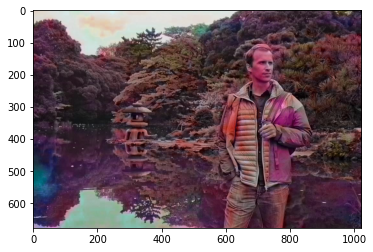

In [118]:
path = "/content/" + "test_finetune_2.jpg"
hue(out_img_eccv16,Image.open(path))